# Lesson 1: Router Engine

Welcome to Lesson 1.

To access the `requirements.txt` file, the data/pdf file required for this lesson and the `helper` and `utils` modules, please go to the `File` menu and select`Open...`.

I hope you enjoy this course!

## Setup

In [1]:
from helper import get_openai_api_key

OPENAI_API_KEY = get_openai_api_key()

In [3]:
import nest_asyncio ## Since most of modules use async

nest_asyncio.apply()

## Load Data

To download this paper, below is the needed code:

#!wget "https://openreview.net/pdf?id=VtmBAGCN7o" -O metagpt.pdf

**Note**: The pdf file is included with this lesson. To access it, go to the `File` menu and select`Open...`.

In [4]:
from llama_index.core import SimpleDirectoryReader

# load documents
documents = SimpleDirectoryReader(input_files=["metagpt.pdf"]).load_data()

In [6]:
print(documents)

[Document(id_='314b0dec-c597-4f01-af15-b1cab6dcd9f4', embedding=None, metadata={'page_label': '1', 'file_name': 'metagpt.pdf', 'file_path': 'metagpt.pdf', 'file_type': 'application/pdf', 'file_size': 16911937, 'creation_date': '2024-07-13', 'last_modified_date': '2024-06-24'}, excluded_embed_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], excluded_llm_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], relationships={}, text='Preprint\nMETAGPT: M ETA PROGRAMMING FOR A\nMULTI -AGENT COLLABORATIVE FRAMEWORK\nSirui Hong1∗, Mingchen Zhuge2∗, Jonathan Chen1, Xiawu Zheng3, Yuheng Cheng4,\nCeyao Zhang4,Jinlin Wang1,Zili Wang ,Steven Ka Shing Yau5,Zijuan Lin4,\nLiyang Zhou6,Chenyu Ran1,Lingfeng Xiao1,7,Chenglin Wu1†,J¨urgen Schmidhuber2,8\n1DeepWisdom,2AI Initiative, King Abdullah University of Science and Technology,\n3Xiamen University,4The Chinese University of

## Define LLM and Embedding model

In [7]:
from llama_index.core.node_parser import SentenceSplitter

splitter = SentenceSplitter(chunk_size=1024)
nodes = splitter.get_nodes_from_documents(documents)

In [17]:
print(len(nodes))

34


In [8]:
from llama_index.core import Settings
from llama_index.llms.openai import OpenAI
from llama_index.embeddings.openai import OpenAIEmbedding

Settings.llm = OpenAI(model="gpt-3.5-turbo")
Settings.embed_model = OpenAIEmbedding(model="text-embedding-ada-002")

## Define Summary Index and Vector Index over the Same Data

Now we will create 2 indices 

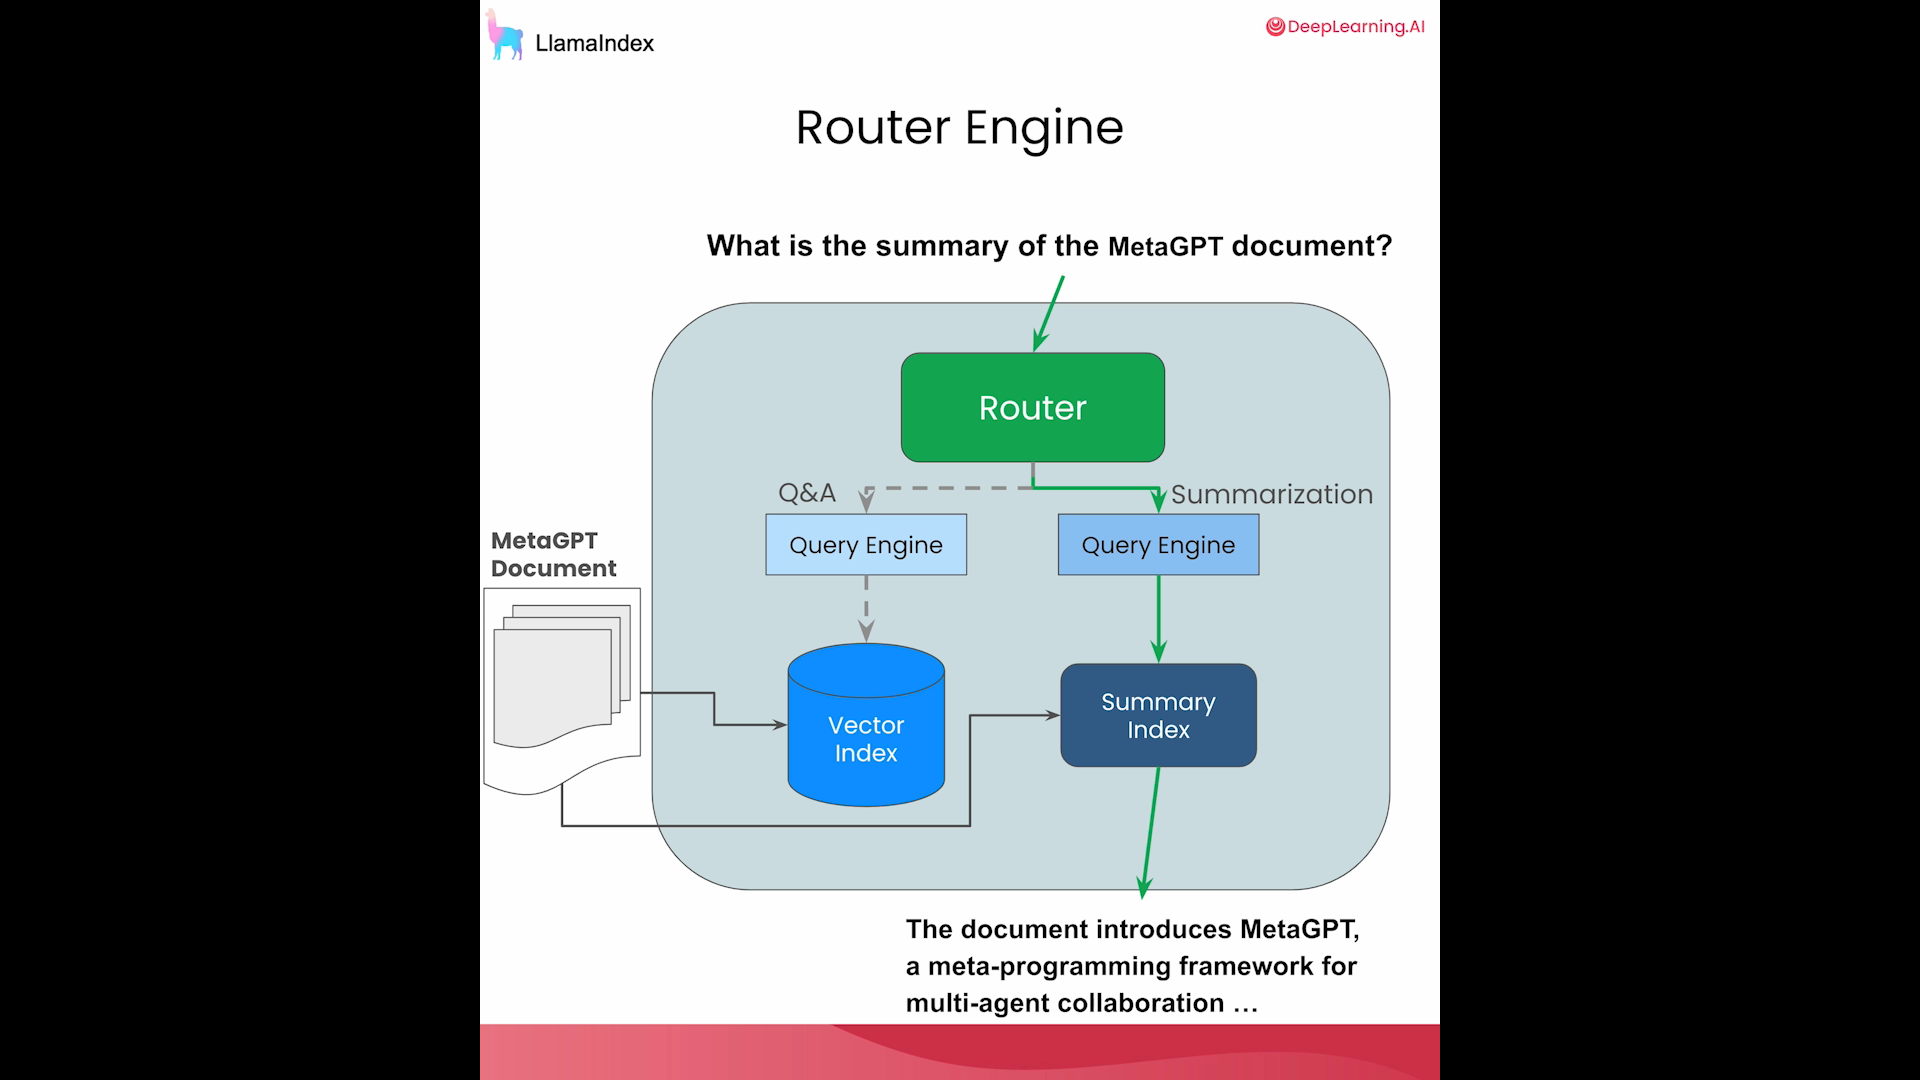

In [9]:
from llama_index.core import SummaryIndex, VectorStoreIndex

summary_index = SummaryIndex(nodes)
vector_index = VectorStoreIndex(nodes) 

## Define Query Engines and Set Metadata

Now we will convert this Indexes into Query Engines .

Each Query Engine represents overall query interface over the data thats stored in index .Each query engine is good for certain type of questions which is a very good use case of Router . Which can Route dynamically between this Query Engines 

In [10]:
summary_query_engine = summary_index.as_query_engine(
    response_mode="tree_summarize",
    use_async=True, ## For faster query generation by leveraging async capabilities 
)
vector_query_engine = vector_index.as_query_engine()

Query Tool - Its just a query engine with metadata . Its a description of what types of question the tool can answer.

In [11]:
from llama_index.core.tools import QueryEngineTool


summary_tool = QueryEngineTool.from_defaults(
    query_engine=summary_query_engine,
    description=(
        "Useful for summarization questions related to MetaGPT"
    ),
)

vector_tool = QueryEngineTool.from_defaults(
    query_engine=vector_query_engine,
    description=(
        "Useful for retrieving specific context from the MetaGPT paper."
    ),
)

## Define Router Query Engine -- Selector - LLMSingle Selector 

LLM Selector - It uses LLM to output a JSON that is parsed and the corresponding indexes are queried

In [12]:
from llama_index.core.query_engine.router_query_engine import RouterQueryEngine
from llama_index.core.selectors import LLMSingleSelector


query_engine = RouterQueryEngine(
    selector=LLMSingleSelector.from_defaults(),
    query_engine_tools=[
        summary_tool,
        vector_tool,
    ],
    verbose=True
)

In [13]:
response = query_engine.query("What is the summary of the document?")
print(str(response))

Selecting query engine 0: Useful for summarization questions related to MetaGPT.
The document introduces MetaGPT, a meta-programming framework that enhances multi-agent systems using Large Language Models (LLMs) by incorporating human-like Standardized Operating Procedures (SOPs) for efficient collaboration. It assigns specific roles to agents, streamlines workflows, and improves task decomposition. MetaGPT utilizes structured outputs and a communication protocol to ensure effective collaboration among agents with diverse expertise. The framework achieves state-of-the-art performance in code generation benchmarks, emphasizes role specialization, workflow management, and efficient communication mechanisms, and inspires future research on human-inspired techniques for artificial multi-agent systems. Additionally, it discusses the software development process with MetaGPT, highlighting the iterative programming approach, executable feedback mechanism, and performance surpassing previous m

In [15]:
print(len(response.source_nodes)) ## Response comes with sources . We can view it using this.

'''
Len of source nodes is same as chunks length . Because Summary Query Engine uses all the chunks that we have for our data

'''

34


In [16]:
print(response.source_nodes)

[NodeWithScore(node=TextNode(id_='bab40fb4-f345-4dd2-aea7-db40989f7b34', embedding=None, metadata={'page_label': '1', 'file_name': 'metagpt.pdf', 'file_path': 'metagpt.pdf', 'file_type': 'application/pdf', 'file_size': 16911937, 'creation_date': '2024-07-13', 'last_modified_date': '2024-06-24'}, excluded_embed_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], excluded_llm_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='314b0dec-c597-4f01-af15-b1cab6dcd9f4', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'page_label': '1', 'file_name': 'metagpt.pdf', 'file_path': 'metagpt.pdf', 'file_type': 'application/pdf', 'file_size': 16911937, 'creation_date': '2024-07-13', 'last_modified_date': '2024-06-24'}, hash='d95a55329a43dd923a51f2db4c97f5262a067c10c44a20c357048a2d37ef3380'), <NodeRelatio

In [18]:
response = query_engine.query(
    "How do agents share information with other agents?"
)
print(str(response))

Selecting query engine 1: This choice is more relevant as it focuses on retrieving specific context from the MetaGPT paper, which may contain information on how agents share information with other agents..
Agents share information with other agents by utilizing a shared message pool where they can publish structured messages. This shared message pool allows all agents to exchange messages directly, enabling them to both publish their own messages and access messages from other agents transparently. Additionally, agents can subscribe to relevant messages based on their role profiles, allowing them to extract the information they need for their specific tasks and responsibilities.


## Let's put everything together

In [19]:
from utils import get_router_query_engine

query_engine = get_router_query_engine("metagpt.pdf")

In [20]:
response = query_engine.query("Tell me about the ablation study results?")
print(str(response))

Selecting query engine 1: Ablation study results are specific context from the MetaGPT paper, making choice 2 the most relevant..
The ablation study results show that MetaGPT effectively addresses challenges related to context utilization, code hallucinations, and information overload in software development. By focusing on unfolding natural language descriptions accurately, maintaining information validity, and utilizing a global message pool with a subscription mechanism, MetaGPT demonstrates improved efficiency and relevance in communication and software generation processes.
